In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import datetime

### I. Les données 

In [2]:
df = pd.read_csv('AirPassengersv2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True) 

df

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
Name: #Passengers, Length: 132, dtype: int64

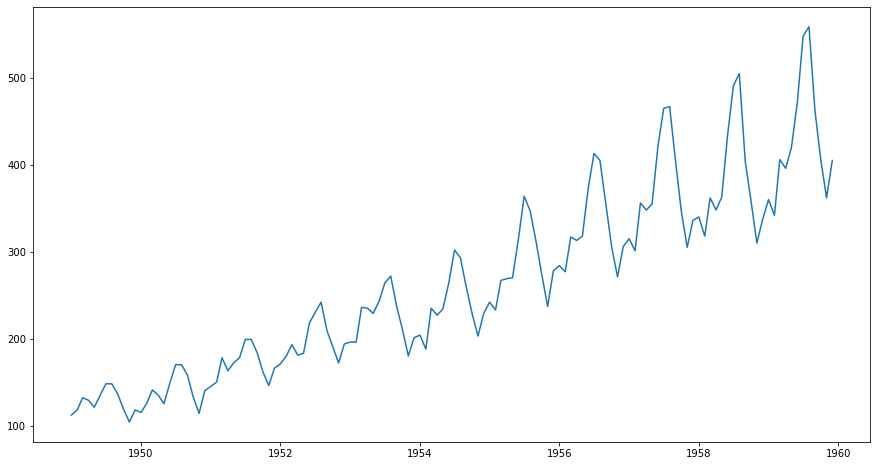

In [3]:
plt.figure(figsize=(15,8))
plt.plot(df);

#### Est-ce un modèle additif ? 

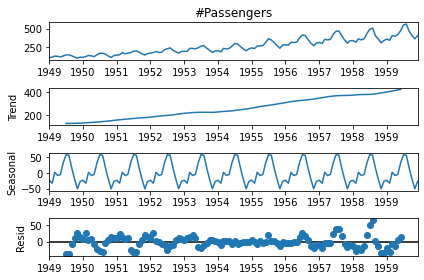

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
TSA=seasonal_decompose(df).plot()

#### Est-ce un modèle multiplicatif ? 

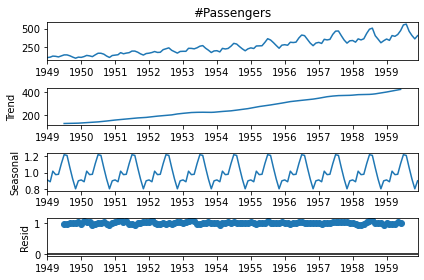

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
TSA=seasonal_decompose(df, model = 'multiplicative').plot()

#### Modèle multiplicatif --> Modèle additif : Passage au log

In [6]:
df = np.log(df)

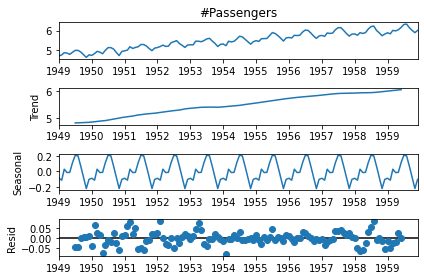

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
TSA=seasonal_decompose(df).plot()

### II. La série est-elle stationnaire ? (Test de ADFuller)

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.317611
p-value: 0.621077


### III. Différenciation + ACF/PACF¶
#### III.1 Sans différenciation

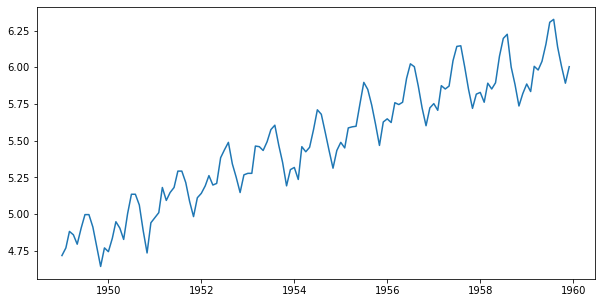

In [9]:
plt.figure(figsize=(10,5))
plt.plot(df);

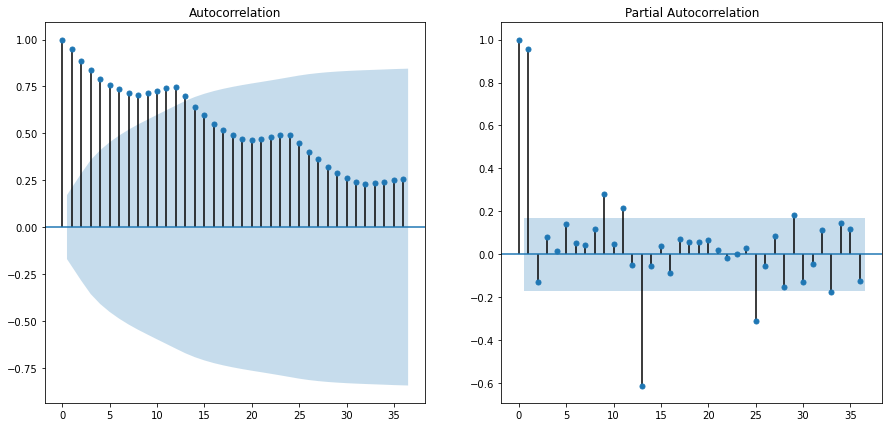

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

plot_acf(df, lags = 36, ax=ax1)
plot_pacf(df, lags = 36, ax=ax2)
plt.show()

#### III.2 Avec différenciation

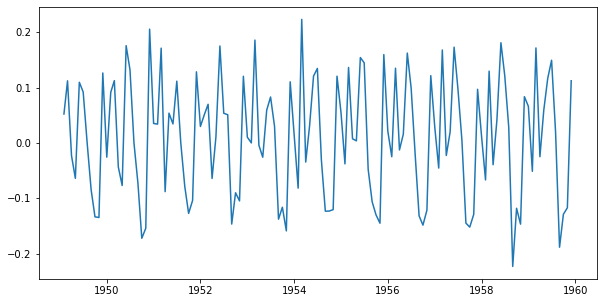

In [11]:
plt.figure(figsize=(10,5))
plt.plot(df.diff());

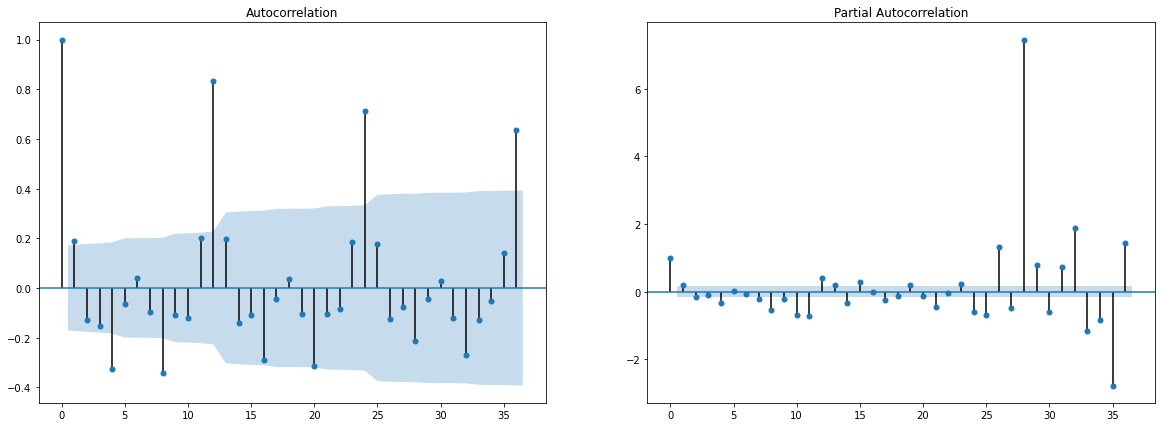

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(df.diff().dropna(), lags = 36, ax=ax1)
plot_pacf(df.diff().dropna(), lags = 36, ax=ax2)
plt.show()

#### III.3 Avec différenciation d'ordre 12

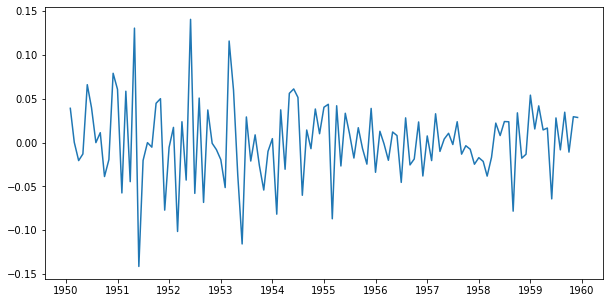

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df.diff().diff(12));

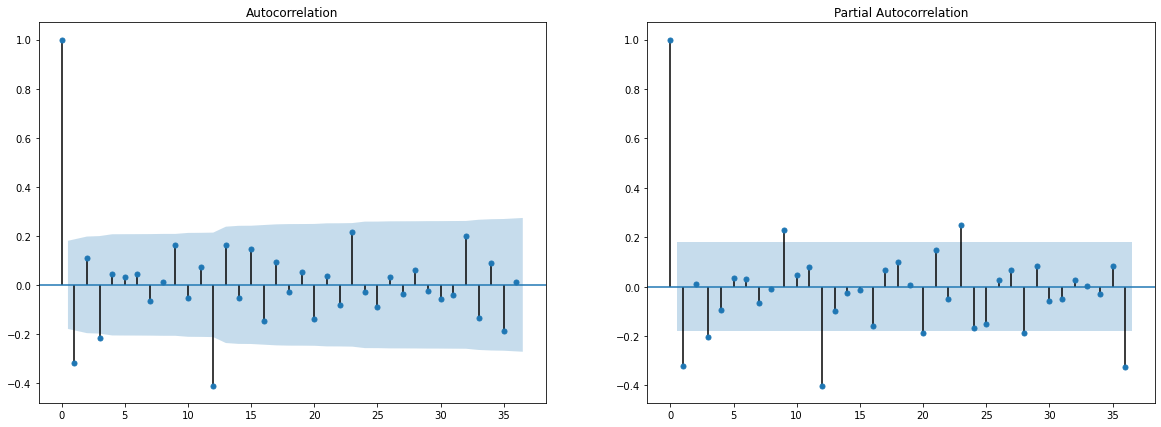

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(df.diff().diff(12).dropna(), lags = 36, ax=ax1)
plot_pacf(df.diff().diff(12).dropna(), lags = 36, ax=ax2)
plt.show()

### IV. Quel modèle ? Quels paramètres ? 

> Modèle ARMA(1,1)

* p = 1
* q = 1

> Pour les ordre saisonniers. Nous regardons les pics saisonniers.

* P = 0
* Q = 1 



In [15]:
model=sm.tsa.SARIMAX(df,order=(1,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.758
Date:                            Thu, 02 Feb 2023   AIC                           -439.516
Time:                                    22:22:08   BIC                           -428.400
Sample:                                01-01-1949   HQIC                          -435.002
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2116      0.236      0.897      0.370      -0.251       0.674
ma.L1         -0.5487      0.207   

In [16]:
model = sm.tsa.SARIMAX(df,order=(0,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.627
Date:                            Thu, 02 Feb 2023   AIC                           -441.253
Time:                                    22:22:09   BIC                           -432.916
Sample:                                01-01-1949   HQIC                          -437.868
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3485      0.081     -4.302      0.000      -0.507      -0.190
ma.S.L12      -0.5622      0.094   

### V. Prédictions

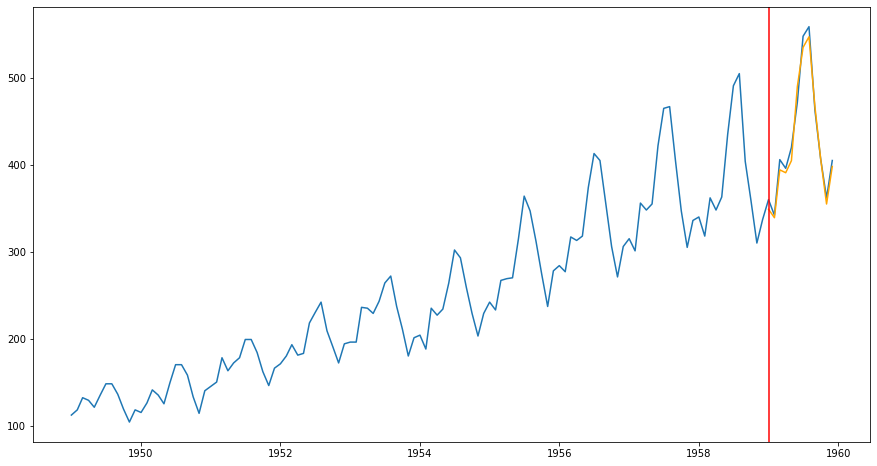

In [19]:
plt.figure(figsize=(15,8))

#df = np.exp(df)
pred = np.exp(sarima.predict(120, 131)) #Prédiction et passage à l'exponentielle

plt.plot(df) #Visualisation

plt.plot(pred,color='orange')

plt.axvline(x= datetime.date(1959,1,1), color='red');

In [22]:
true = df[120:133].values
err = pred.values-true
np.mean(err)/np.mean(true) * 100

-1.2092059247916433